In [794]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Analyzing the dataset

Loading required libraries

In [795]:
import pandas as pd
import numpy as np
import datetime
from matplotlib import pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX

import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

Loading training set

In [796]:
train_data = pd.read_csv('train.csv', index_col=0)
train_data.head()

,Date,Open,Close,Volume,Strategy
id,,,,,
0,01-06-2015,66.208486,75.609978,298506300,Hold
1,08-06-2015,64.116235,74.443331,227974800,Hold
2,15-06-2015,47.701942,71.140831,250670900,Buy
3,22-06-2015,54.754816,72.881344,223614300,Hold
4,29-06-2015,48.031900,66.284718,406814900,Buy


Augmented Dickey-Fuller Test

In [797]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(train_data['Close'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('#Lags Used:', result[2])
print('Number of Observations Used:', result[3])
print('Critical Values:', result[4])  

ADF Statistic: -1.8080055427886537
p-value: 0.37649446970992734
#Lags Used: 1
Number of Observations Used: 298
Critical Values: {'1%': -3.4524859843440754, '5%': -2.871288184343229, '10%': -2.571964047565425}


We can see that p > 0.05, hence the data is not stationary. 
We need to implement some sort of differencing to make the data stationary. 

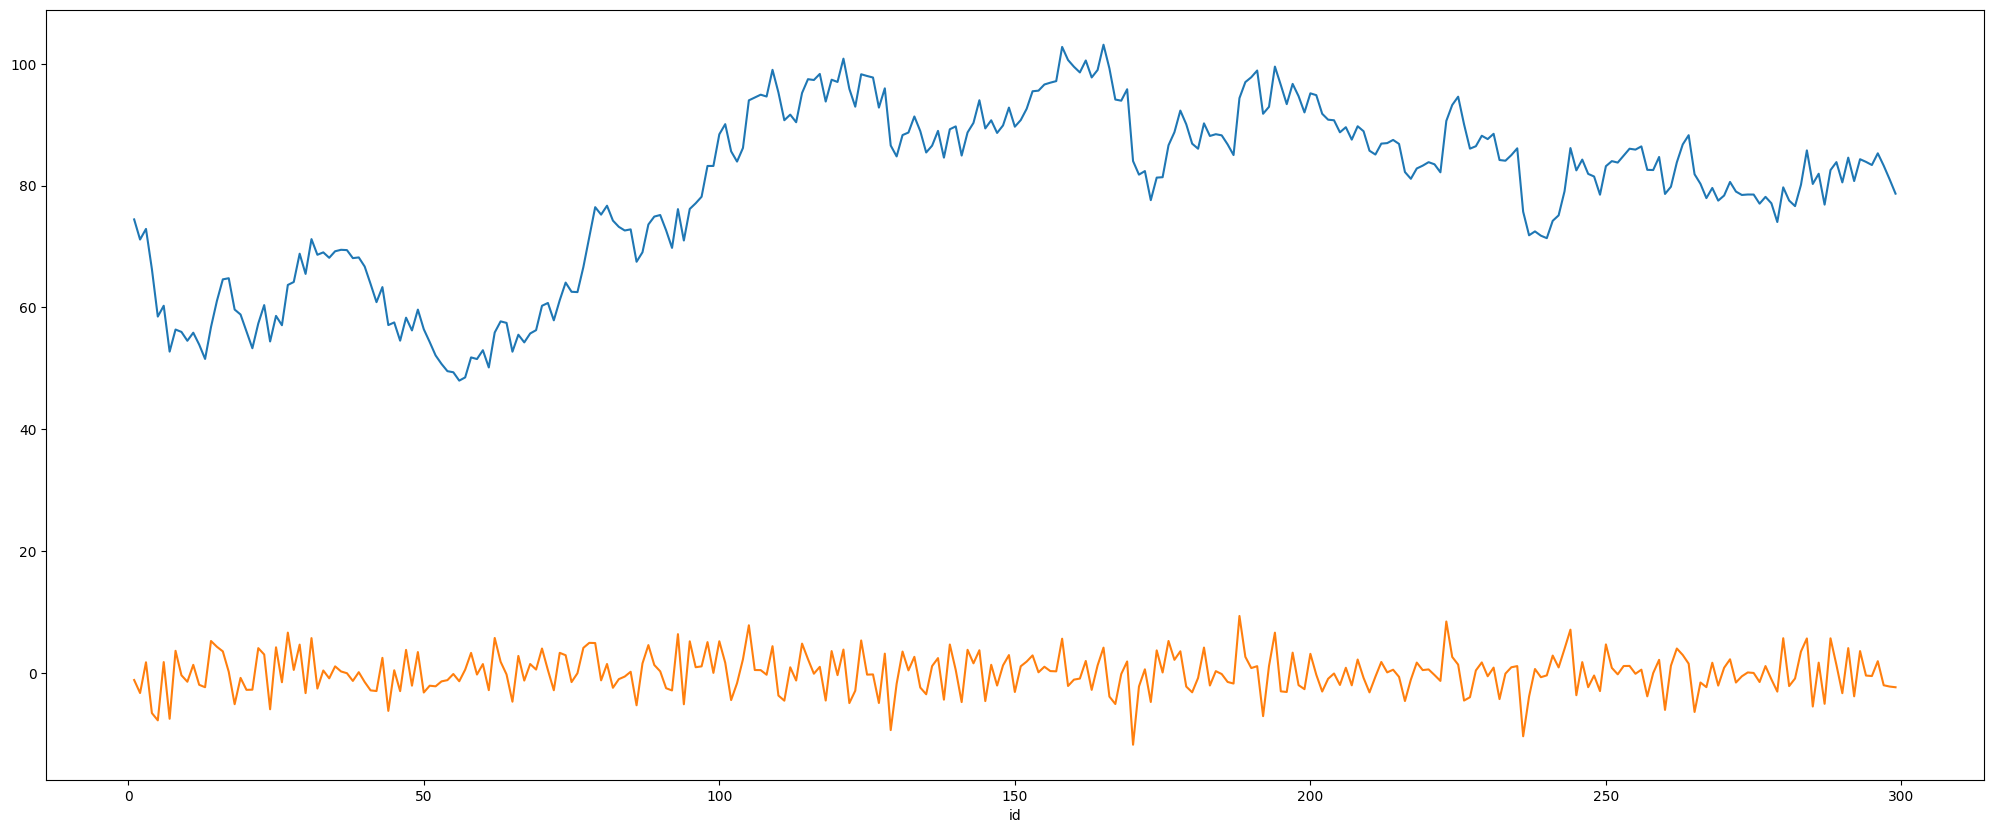

In [798]:
train_data['Close_diff'] = train_data['Close'].diff(1)
train_data.dropna(inplace=True)

train_data['Close'].plot(figsize=(25,10))
train_data['Close_diff'].plot(figsize=(25,10))
plt.show()

In [799]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(train_data['Close_diff'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('#Lags Used:', result[2])
print('Number of Observations Used:', result[3])
print('Critical Values:', result[4])

ADF Statistic: -19.615947590717283
p-value: 0.0
#Lags Used: 0
Number of Observations Used: 298
Critical Values: {'1%': -3.4524859843440754, '5%': -2.871288184343229, '10%': -2.571964047565425}


Large negative ADF statistic=-19.615947590717283 suggests that the time series is stationary and can clearly reject the null hypothesis 

Analyzing seasonal trends

<Figure size 640x480 with 0 Axes>

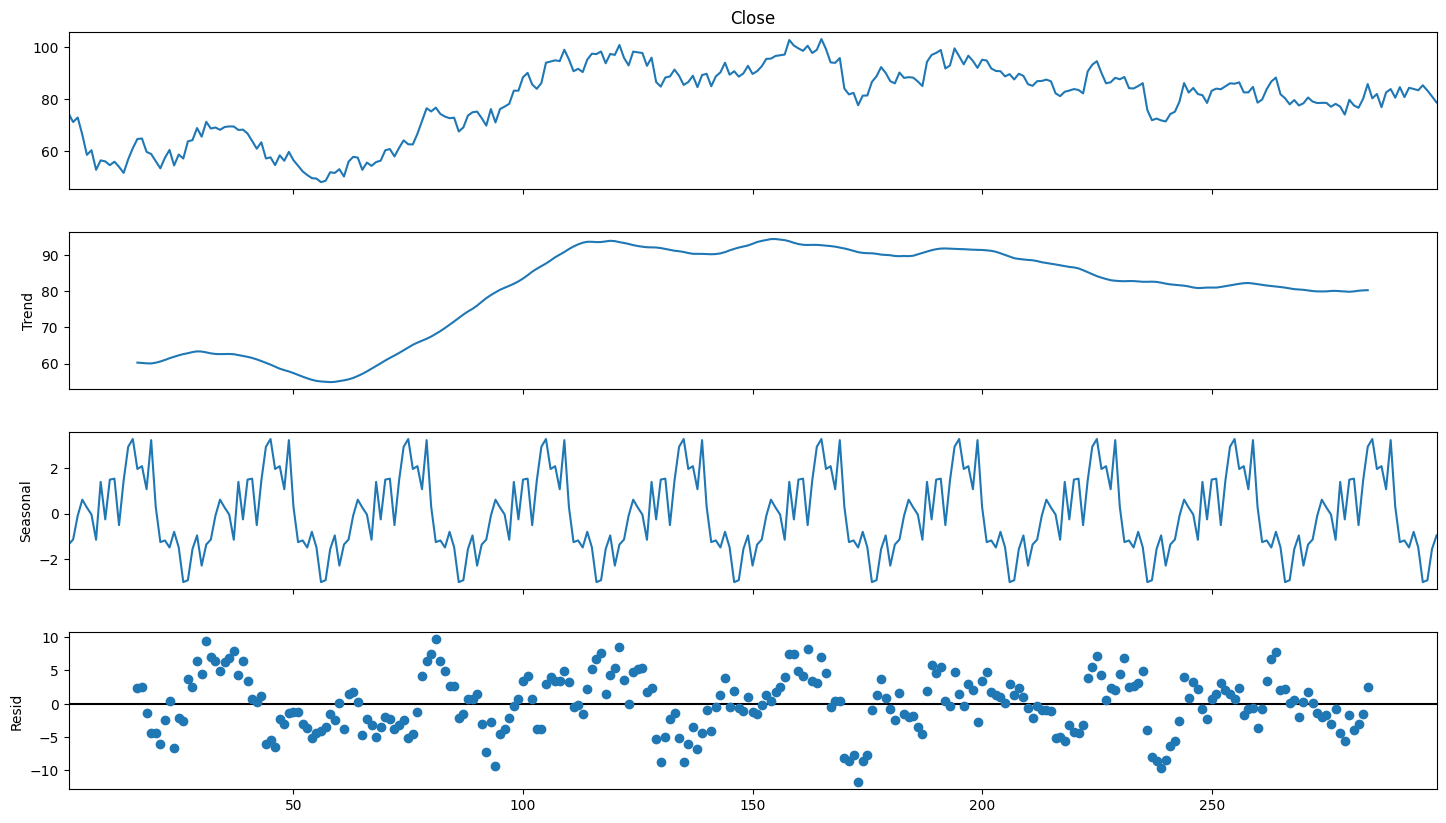

In [800]:
from statsmodels.tsa.seasonal import seasonal_decompose
train_data = train_data.dropna()
result = seasonal_decompose(train_data['Close'], model='additive',period = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

The trend is not showing any repetitions, it means that there is some seasonality in the dataset.
We would consider a SARIMA model as data is stationary after differencing and shows clear seasonal patterns.

Autocorrelation (ACF) Plot

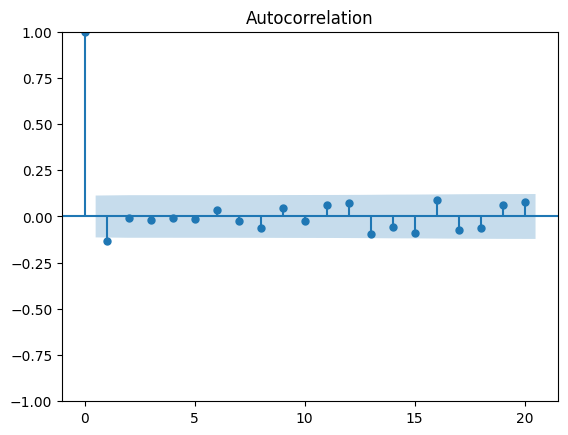

In [801]:
plot_acf(train_data.Close_diff,lags=20)
plt.show()

Partial Autocorrelation (PACF) Plot

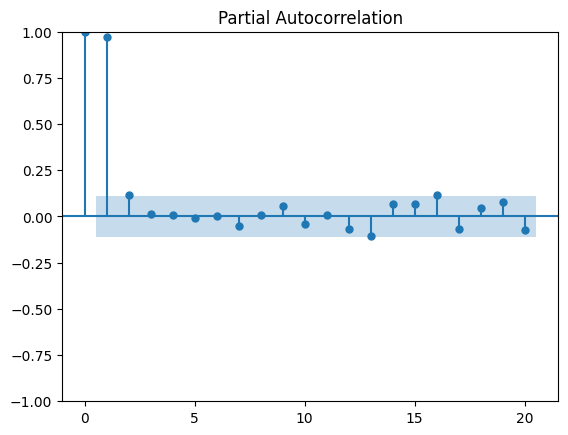

In [802]:
plot_pacf(train_data.Close,lags=20)
plt.show()

From acf and pcaf plots, (p, d, q) = (1, 0, 1)

## Predicting 'Close' Prices

## Training the model

Splitting train.csv into training set:validation set = 80:20 ratio. 


Feature engineering is done, i.e, adding on features from the existing data to tackle underfitting

Building a SARIMAX model with the found order (1, 0, 1) endogeneous variable as 'Close' and exogeneous variables as ['Open', 'Volume', 'Volume/Open', 'Open_Lag1', 'Volume_Lag1', 'Volume_RollingMean', 'Volume_RollingStd', 'Open_SMA', 'Volume_SMA']

In [803]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Load train.csv and set 'Date' column as index
data = pd.read_csv('train.csv', index_col=0)

# Feature Engineering
data['Volume/Open'] = data['Volume'] / data['Open']
data['Open_Lag1'] = data['Open'].shift(1)
data['Volume_Lag1'] = data['Volume'].shift(1)
data['Volume_RollingMean'] = data['Volume'].rolling(window=3).mean()
data['Volume_RollingStd'] = data['Volume'].rolling(window=3).std()
data['Open_SMA'] = data['Open'].rolling(window=3).mean()
data['Volume_SMA'] = data['Volume'].rolling(window=3).mean()
data = data.fillna(1e10)
# Split data into training and validation sets
train_size = int(0.8 * len(data))
train = data[:train_size]
validation = data[train_size:]

# SARIMAX Model
endog_train = train['Close']
exog_train = train[['Open', 'Volume', 'Volume/Open', 'Open_Lag1', 'Volume_Lag1', 'Volume_RollingMean', 'Volume_RollingStd', 'Open_SMA', 'Volume_SMA']]
endog_validation = validation['Close']
exog_validation = validation[['Open', 'Volume', 'Volume/Open', 'Open_Lag1', 'Volume_Lag1', 'Volume_RollingMean', 'Volume_RollingStd', 'Open_SMA', 'Volume_SMA']]

# Build SARIMAX model with order (2, 1, 1)
sarimax_model = SARIMAX(endog=endog_train, exog=exog_train, order=(1, 0, 1))
sarimax_result = sarimax_model.fit(disp=False)

# Forecast 'Close' prices for the validation set
forecasted_close = sarimax_result.get_forecast(steps=len(validation), exog=exog_validation)
forecasted_close_mean = forecasted_close.predicted_mean

# Calculate SMAPE for forecasted 'Close' and validation set 'Close'
smape = np.mean(np.abs(forecasted_close_mean - endog_validation) / (np.abs(forecasted_close_mean) + np.abs(endog_validation) + 1e-10)) * 100

print(f"SMAPE on validation set: {smape}")


SMAPE on validation set: 2.388297955763411


c:\Users\srira\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SMAPE on validation set is 2.388297955763411. Which means that our predictions are 100-2.39 = 97.61% accurate

## Testing the trained SARIMAX model on test data

In [804]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Load test.csv and set 'Date' column as index
test_data = pd.read_csv('test.csv', index_col=0)

# Feature Engineering for test data
test_data['Volume/Open'] = test_data['Volume'] / test_data['Open']
test_data['Open_Lag1'] = test_data['Open'].shift(1)
test_data['Volume_Lag1'] = test_data['Volume'].shift(1)
test_data['Volume_RollingMean'] = test_data['Volume'].rolling(window=3).mean()
test_data['Volume_RollingStd'] = test_data['Volume'].rolling(window=3).std()
test_data['Open_SMA'] = test_data['Open'].rolling(window=3).mean()
test_data['Volume_SMA'] = test_data['Volume'].rolling(window=3).mean()

test_data = test_data.fillna(-1e10)  # Fill NaN values with a very small negative number

# Prepare exogenous variables for SARIMAX model
exog_test = test_data[['Open', 'Volume', 'Volume/Open', 'Open_Lag1', 'Volume_Lag1', 'Volume_RollingMean', 'Volume_RollingStd', 'Open_SMA', 'Volume_SMA']]

# Apply the trained SARIMAX model on the test data
forecasted_close_test = sarimax_result.get_forecast(steps=len(exog_test), exog=exog_test)
forecasted_close_test_mean = forecasted_close_test.predicted_mean

# Assuming forecasted_close_test_mean is your DataFrame
forecasted_close_test_mean.reset_index(drop=True, inplace=True)

test_data['Close'] = forecasted_close_test_mean

# Print the forecasted 'Close' values for test data
print("Forecasted 'Close' values for test data:")
print(forecasted_close_test_mean)


Forecasted 'Close' values for test data:
0     68.080860
1     66.239126
2     72.799430
3     72.538071
4     70.569879
        ...    
95    61.680129
96    64.381301
97    65.139518
98    60.065615
99    61.562566
Name: predicted_mean, Length: 100, dtype: float64


The predicted 'Close' prices for test.csv are in forecasted_close_test_mean and stored in test_data['Close']

In [805]:
submission = pd.DataFrame()
submission['Date'] = test_data['Date']
submission['Open'] = test_data['Open']
submission['Close'] = forecasted_close_test_mean

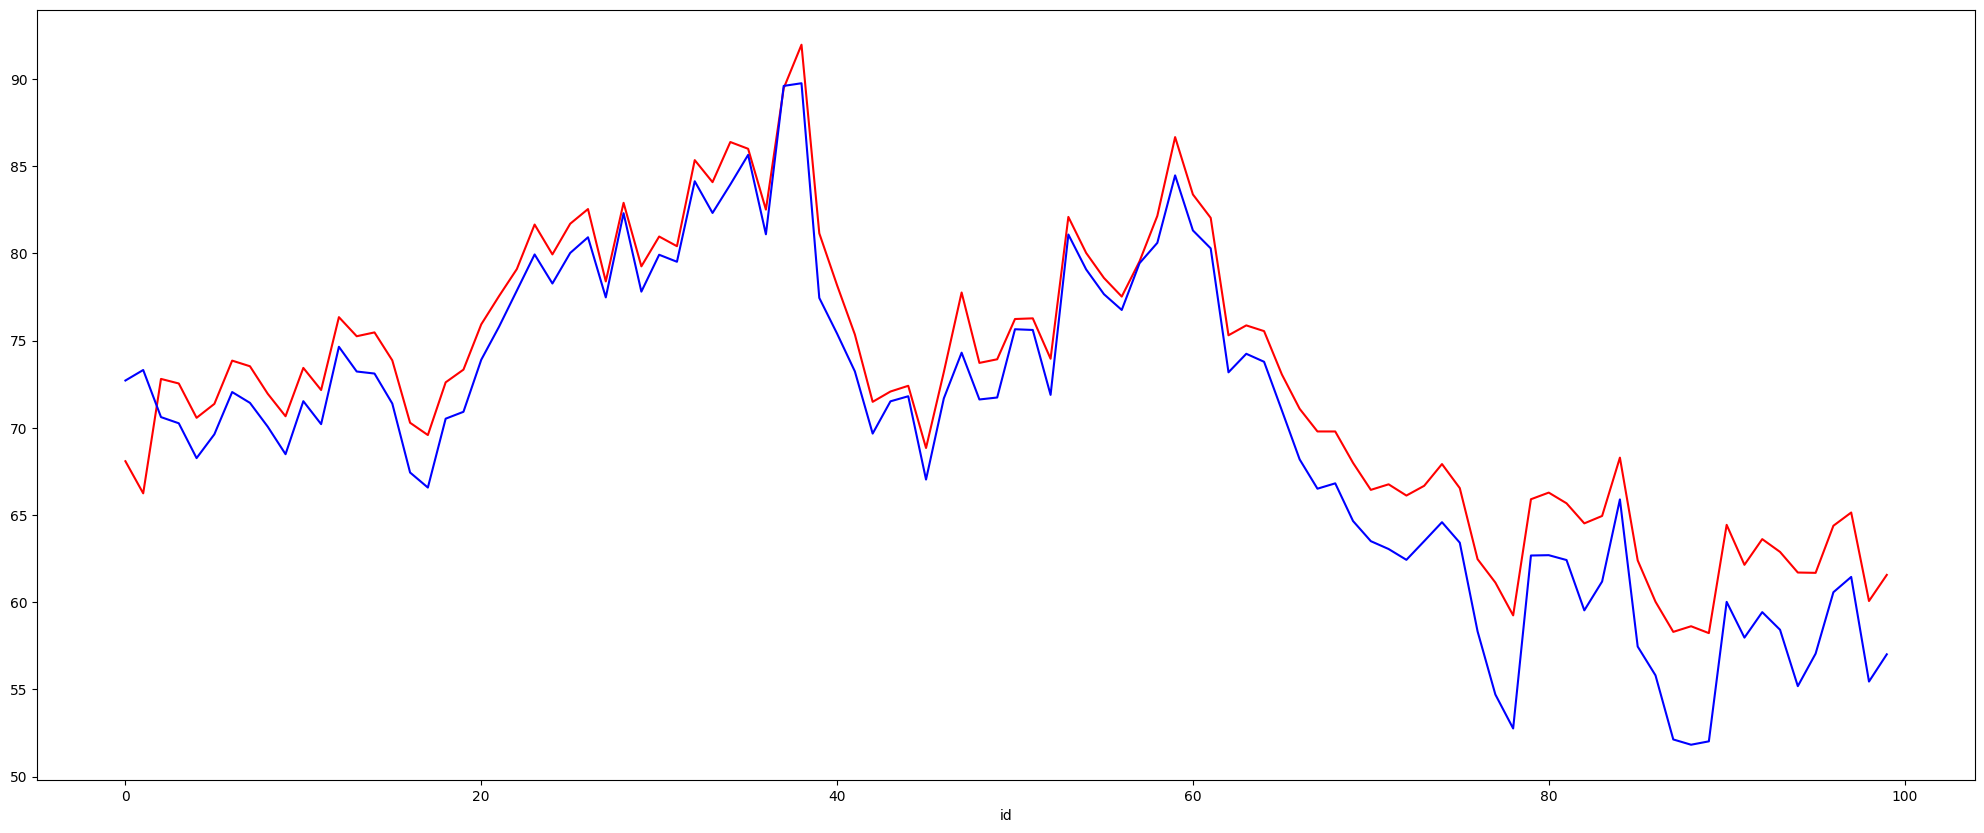

In [806]:
submission['Close'].plot(figsize=(25,10),color = 'red')
test_data['Open'].plot(figsize=(25,10),color = 'blue')
plt.show()

This is how near the 'Close' and 'Open' prices in test_data are. And generally, the open and close prices don't differ way to far in the real world. Our predictions of 'Close' prices are highly accurate.

In [807]:
submission.describe()

,Open,Close
count,100.000000,100.000000
mean,70.265016,72.688807
std,9.010469,7.789087
min,51.825792,58.224521
25%,63.318829,66.399553
50%,71.470649,72.927950
75%,77.451497,78.439492
max,89.752238,91.961230
